# Algorithm testing

In [1]:
from retinanet.dataloader import CustomDataset, collater, Resizer, Augmenter, Normalizer
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from torchvision import transforms
import torchvision
import numpy as np
import cv2
import skimage.io
import skimage.transform
import skimage.color
import skimage
import os, sys, inspect
from matplotlib import pyplot as plt
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
import object_detection
from object_detection import my_utils
from my_resnet import utils
from my_resnet import resnet
from my_resnet.resnet import resnet18, resnet50, resnet101, resnet152
import time

### Function definition

In [2]:
def add_boxes_to_image(real_box, real_label, pred_box, pred_label, image, image_name, algo_name, class_list):
    text_size = image.shape[0] / 600
    if text_size < 1:
        text_size = 1
    text_thickness = int(text_size * 3)
    print("font parameters : ", text_size, text_thickness)
    image = cv2.rectangle(image, (int(real_box[0]), int(real_box[1])), (int(real_box[2]), int(real_box[3])),
                           (0, 255, 0), text_thickness)
    text = class_list[int(real_label)]
    image = cv2.putText(img = image, text = text, org = (int(real_box[0]), int(real_box[3] - 10 * text_size)), fontFace = cv2.FONT_HERSHEY_SIMPLEX ,
                     fontScale = text_size, color = (0, 255, 0), thickness = text_thickness, lineType = cv2.LINE_AA)
    image = cv2.rectangle(image, (int(pred_box[0]), int(pred_box[1])), (int(pred_box[2]), int(pred_box[3])), (255, 0, 0), text_thickness)
    text2 = class_list[int(pred_label)]
    print("real class = ", text, ", predicted class = ", text2)
    image = cv2.putText(img = image, text = text, org = (int(pred_box[0]), int(pred_box[1] + 20 * text_size)), fontFace = cv2.FONT_HERSHEY_SIMPLEX ,
                     fontScale = text_size, color = (255, 0, 0), thickness = text_thickness, lineType = cv2.LINE_AA)
    plt.imshow(image)
    plt.show()
    cv2.imwrite("images/bboxes_"+algo_name+ "_"+image_name, image)

In [3]:
folder_path = "/home/orumfels/datasets/triscandata/val/"
class_list = ['Aerosol','Bout./flac < 8L', "Bout./flac > 8L",
           "Emballage metallique", "Huile de friture", "Carton a boisson", "Papier-carton",
           "Verre incolore", "Verre colore", "FR", "PDP", "DSM"]

##### Random choice of image:

In [4]:
choice_dataset = CustomDataset(folder_path, class_list, transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]),
                        set_name='test', train = False, data_augment=False)

Initializing Custom Dataset...
not just one image : /home/orumfels/datasets/triscandata/val/


100% |########################################################################|


In [20]:
image_name = choice_dataset.get_filename(np.random.randint(0, len(choice_dataset)))
print("chosen image =", image_name)
path = folder_path+ image_name

chosen image = 9adfede7-0805-47bd-8782-ffa8ec5afd49.jpg


## RetinaNet

In [6]:
# load model
print("Loading model")
weight_path = "/home/orumfels/tfe_my_implementations/pytorch-retinanet/work_dir/triscandata/50/data_augment/70.pt"
model = torch.load(weight_path, map_location=torch.device('cpu'))

Loading model


In [18]:
# default transform = None, and data_augment = False
dataset = CustomDataset(image_name, class_list, transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]),
                        set_name='test', train = False, data_augment=False)

# get detection
data = dataset[0]
print("image name :", dataset.get_filename(0))
model.eval()
start = time.time()
if torch.cuda.is_available():
    scores, labels, boxes = model(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
else:
    scores, labels, boxes = model(data['img'].permute(2, 0, 1).float().unsqueeze(dim=0))

print("time for 1 prediction : ", time.time() - start)
max_index = torch.argmax(scores).numpy()

Initializing Custom Dataset...
just one image


image name : b5cbaa5b-425f-4070-b87b-37f9cefa82c9.jpg
time for 1 prediction :  1.358534336090088


ANNOT : [[ 15.12962963 255.97222222 445.44444444 782.16666667   1.        ]] , scale = 0.17592592592592593
ORIGINAL IMAGE SIZE :  (4608, 3456, 3)
ORIGINAL SCALED BOXES =  [  86. 1455. 2532. 4446.]
new boxes : [ 127.06096 1452.5444  2579.1182  4333.0454 ]
labels : 1.0 1
font parameters :  7.68 23
real class =  Bout./flac < 8L , predicted class =  Bout./flac < 8L


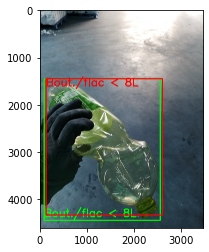

In [19]:
# load image
image = cv2.imread(path)
scale = data['scale']

# load original box
annot = data['annot'].detach().numpy()
print("ANNOT :", annot, ", scale =", scale)
print("ORIGINAL IMAGE SIZE : ", image.shape)
ori_boxes = annot[0, :4]
ori_class = annot[0, 4]
ori_boxes /=scale
print("ORIGINAL SCALED BOXES = ", ori_boxes)
x_min = int(ori_boxes[0])
x_max = int(ori_boxes[2])
y_min = int(ori_boxes[1])
y_max = int(ori_boxes[3])

# Load predicted boxes
new_box = boxes[max_index].detach().numpy()
new_box /= scale
new_label = labels[max_index].detach().numpy()
print("new boxes :", new_box)
print("labels :", ori_class, new_label)
add_boxes_to_image(ori_boxes, ori_class, new_box, new_label, image, image_name, "retinanet40", class_list)

# ResNet

In [ ]:
json_file = "/home/orumfels/datasets/triscandata/annotations/instances_train.json"
dataset = utils.CustomDataset(path, class_list, json_file, data_augment = False)
testloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
# load model 
model = resnet50(3, 12) #3 = nb channels, 12 = nb classes
model_path = '/home/orumfels/tfe_my_implementations/my_resnet/models/triscan/resnet50/data_augment/10.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

In [ ]:
for inputs, targets in testloader:
    start = time.time()
    outputs = model(inputs)
    print("time for 1 prediction : ", time.time() - start)
    _, predicted = outputs.max(1)
    print("Real label =", class_list[int(targets.numpy())], ", predicted =", class_list[int(predicted.numpy())])

## Faster RCNN

In [124]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

In [125]:
# load model
model_path = '/home/orumfels/tfe_my_implementations/object_detection/work_dir/faster_rcnn_resnet50_8_12classes.pth'
num_classes = 12
#class_list = [ '', 'Bout./flac. en plastique', "Emballage metallique", "Huile de friture", "Papier-carton","Verre","DSM"]
# get the model using our helper function
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [126]:
json_file = "/home/orumfels/datasets/triscandata/annotations/instances_val.json"
dataset = my_utils.CustomDataset(path, class_list, json_file, data_augment = False)
testloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

only one file : ['becdc616-4bac-45bb-8212-f383a912c4b7.jpg']
number of images : 1


In [127]:
for inputs, targets in testloader:
    start = time.time()
    output = model(inputs)
    print("time for 1 prediction : ", time.time() - start)
    scores = output[0]['scores']
    labels = output[0]['labels']
    boxes = output[0]['boxes']
    max_index = torch.argmax(scores).numpy()
    predicted_label = labels[max_index]
    predicted_box = boxes[max_index]
    print("Real label =", targets['boxes'], targets['labels'], ", predicted =", predicted_label, predicted_box)

time for 1 prediction :  2.032764196395874
Real label = tensor([[[ 38.8148,  37.1111, 213.7037, 170.2222]]], dtype=torch.float64) tensor([[6]]) , predicted = tensor(3) tensor([ 46.8495,  87.3915, 169.8120, 178.5006], grad_fn=<SelectBackward>)


In [128]:
# load image
image = cv2.imread(path)
height, width, z = image.shape

# load original box
boxes = targets['boxes'].numpy()[0][0]
boxes[0] = boxes[0] / (224/width)
boxes[1] = boxes[1] / (224/height)
boxes[2] = boxes[2] / (224/width)
boxes[3] = boxes[3] / (224/height)
label = targets['labels'].numpy()[0][0]

# Load predicted boxes
predicted_box = predicted_box.detach().numpy()
print(predicted_box)
predicted_box[0] = predicted_box[0] / (224/width)
predicted_box[1] = predicted_box[1] / (224/height)
predicted_box[2] = predicted_box[2] / (224/width)
predicted_box[3] = predicted_box[3] / (224/height)
predicted_label = predicted_label.numpy() -1
print("new boxes :", predicted_box)
print("real boxes :", boxes)
print("image shape :", image.shape)
print("labels = ", label, predicted_label)
add_boxes_to_image(boxes, label, predicted_box, predicted_label, image, image_name, "faster_0", class_list)

[ 46.849537  87.391525 169.812    178.50058 ]
new boxes : [ 632.46875 1573.0475  2292.462   3213.0105 ]
real boxes : [ 524.  668. 2885. 3064.]
image shape : (4032, 3024, 3)
labels =  6 2
